# Question 1

Download the following time series from the website: HW#5TimeSeries1.txt. Calculate and
plot the power spectrum for the time series using the analysis constraints outlined below. Again,
assumeΔt =1 month. In all plots, include (a) the power spectrum, (b) the experimental red-noise
power spectrum, and (c) the 95% significance curve as done in class. You may plot the power versus
frequency or period - your choice. However, use the same axis for all cases.

In [1]:
#-------------------------------------------------------------------
# Import libraries.
#-------------------------------------------------------------------
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import MultipleLocator
from scipy import signal

warnings.simplefilter('ignore')

In [2]:
y = np.loadtxt('HW#5TimeSeries1.txt')

In [3]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat, trend

In [4]:
y_ano= y - y.mean()
y_detrend,_,_ = detrend(y_ano)

In [5]:
class PowerSpectrum(object):
    '''
    Power spectrum analysis with three techniques and significance test
    
    Examples:
    --------------------------
    #with normal condition
    ps= PowerSpectrum(y,dt=1,detrend=True,window=False)
    x, ps_curve, rn_curve, sig_curve= ps.normal()
    
    #with running mean (smooth_window=5)
    ps= PowerSpectrum(y,dt=1,detrend=True,window=False)
    x, ps_curve, rn_curve, sig_curve= ps.running_mean(window=5)
    
    #with window (hann window) tapering
    ps= PowerSpectrum(y,dt=1,detrend=True,window=True, subset=5)
    x, ps_curve, rn_curve, sig_curve= ps.window(fw=1.2)
    '''
    
    def __init__(self, y, dt=1, detrend=True, window=False, **window_params):
        '''
        Args:
        ---------------------
        :y - np.ndarray; geophysical values (anomaly)
        :dt - int; time step;
        :detrend - bool; whether to detrend your data;
        :window - bool; whether to adopt taper and subdivision
        :window_params: dict {'subset': int,
                              ...
                              }
                              
        '''
        if detrend:
            y,_ ,_ = self._detrend(y)
        num= len(y)
        self.N = int(np.floor(num/2.)*2)
        self.y = y[:self.N]
        self.nyquist= int(self.N/2)
        self.T= dt * self.N
        i = np.arange(1,self.N+1)
        if window:
            self.subset= window_params.get('subset')
            segments= self.subset*2-1
            num = len(y)/self.subset #The length of the time series over which to conduct power spectrum analysis
            self.N = int(np.floor(num/2.)*2)
            self.nyquist= int(self.N/2)
            self.T= dt * self.N
            i = np.arange(1,self.N+1)
            A = np.ones((self.nyquist+1,segments))*np.nan
            B = np.ones((self.nyquist+1,segments))*np.nan
            self.rho= []
            w= signal.windows.hann(self.N)
            #--------compute each subset-----------#
            for n in range(self.subset):
                ysub = y[n*self.N:(n+1)*self.N]
                self.rho.append(stats.pearsonr(ysub[1:], ysub[:-1])[0])
                ysub*= w

                for k in range(1, self.nyquist): #resolve the lowest frequency
                    A[k,n] = 2./self.N*(ysub*np.cos(2*np.pi*k*i*dt/self.T)).sum()
                    B[k,n] = 2./self.N*(ysub*np.sin(2*np.pi*k*i*dt/self.T)).sum()
                k= self.nyquist
                A[k,n] = 1/self.N*(ysub*np.cos(np.pi*self.N*i*dt/self.T)).sum()
                B[k,n]= 0 
            #---------compute overlaping----------#
            start= self.N//2
            for n in range(self.subset, segments):
                ysub= y[start:start+self.N]
#                 print(start,start+self.N)
                self.rho.append(stats.pearsonr(ysub[1:], ysub[:-1])[0])
                ysub*= w
                for k in range(1, self.nyquist): #resolve the lowest frequency
                    A[k,n] = 2./self.N*(ysub*np.cos(2*np.pi*k*i*dt/self.T)).sum()
                    B[k,n] = 2./self.N*(ysub*np.sin(2*np.pi*k*i*dt/self.T)).sum()
                k= self.nyquist
                A[k,n] = 1/self.N*(ysub*np.cos(np.pi*self.N*i*dt/self.T)).sum()
                B[k,n]= 0 
                start+=self.N
            C2= (A**2+ B**2)[1:]

            self.C2 = np.nanmean(C2.copy(), axis=1)
            
        else:
            A = np.ones((self.nyquist+1,))*np.nan
            B = np.ones((self.nyquist+1,))*np.nan
            for k in range(1,self.nyquist):
                A[k] = 2./self.N*(self.y*np.cos(2*np.pi*k*i*dt/self.T)).sum()
                B[k] = 2./self.N*(self.y*np.sin(2*np.pi*k*i*dt/self.T)).sum()
            #-------------------------------------------------------------------
            # Calculate A_k and B_k at k = nyquist.
            #-------------------------------------------------------------------
            k = self.nyquist
            A[k] = 1/self.N*(self.y*np.cos(np.pi*self.N*i*dt/self.T)).sum()
            B[k] = 0

            #-------------------------------------------------------------------
            # Calculate C_k**2 - i.e., the total magnitude.
            #-------------------------------------------------------------------
            C2 = A**2 + B**2
            self.C2 = C2[1:].copy() # Keep only the k = 1, 2, 3,... values. Skip the k=0 wave.
            self.rho= stats.pearsonr(self.y[1:], self.y[:-1])[0]
    
    def normal(self, priori=False):
        '''
        Return the scaled results for angular frequency, power specturm density, red noise power specturm
        and significance curve for plot
        '''
        C2= self.C2
        dof=2
        rho= self.rho
        return self.sig_test(C2, dof, rho, priori)
    
    def running_mean(self,window, priori=False):
        '''
        Return the scaled results for angular frequency, power specturm density, red noise power specturm
        and significance curve for plot
        '''        
        dof=2
        RUNMEAN = window
        C2 = np.convolve(self.C2, np.ones((RUNMEAN,))/RUNMEAN)[(RUNMEAN-1):] #Fast way of doing a running mean.
        dof*=RUNMEAN # Applying a running mean increases the degrees of freedom for significance
                         # testing.
        rho= np.nanmean(self.rho)
        
        return self.sig_test(C2, dof, rho, priori)
    
    def window(self,fw=1.2, priori=False):
        '''
        Return the scaled results for angular frequency, power specturm density, red noise power specturm
        and significance curve for plot
        '''        
        C2= self.C2
        fw= fw
        dof= np.ceil(2*self.subset*fw)
        rho= np.nanmean(self.rho)
        
        return self.sig_test(C2, dof, rho, priori)
    
    
    def sig_test(self, C2, dof, rho, priori=False):
        #significance test
        k = np.arange(1,self.nyquist+1) # Wavenumbers
        omega = 2*np.pi*k/self.N # Angular frequency

        sigma_e2 = (1-rho**2)*np.var(self.y)

        rnPower = 4*sigma_e2**2/self.N/(1+rho**2-2*rho*np.cos(omega))
        delta = omega[1]-omega[0]
        scaledPower = C2/np.nansum(delta*C2)
        scaledRN = rnPower/np.nansum(delta*rnPower)
        
        alphaStar = 0.05
        if priori: alpha=alphaStar
        else: alpha = alphaStar/self.nyquist

        sigChi2 = stats.chi2.isf(alpha,dof) # Chi-squared value for the nominal alpha value for your 95% test.

        sigCurve = scaledRN / dof *sigChi2 
        
        return omega, scaledPower, scaledRN, sigCurve
    
    def _detrend(self,y):
        '''
        linear regression to detrend

        Args:
        -------------------
        :y - numpy.ndarray; target to detrend

        Returns:
        -------------------
        :detrend - numpy.ndarray; 
        '''

        t= np.arange(len(y))
        E= np.ones((t.size,2))*np.nan
        E[:,0] = t
        E[:,1] = 1
        xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
        trend = E.dot(xhat)
        detrend= y- trend

        return detrend, xhat, trend

## Case a:

Lowest resolved frequency: 2$\pi$ per N. No window tapering and no smoothing.

In [6]:
num = len(y_detrend) #The length of the time series over which to conduct power spectrum analysis
N = int(np.floor(num/2.)*2) # Get an even number of points for the power spectrum analysis.

y_detrend = y_detrend[:N] # Retain an even number of points.

nyquist = int(N/2)


dt = 1. # Timestep
T = dt*N #Total time length

i = np.arange(1,N+1) #Discrete counter for the points in y.

A = np.ones((nyquist+1,))*np.nan
B = np.ones((nyquist+1,))*np.nan

for k in range(1,nyquist):
    A[k] = 2./N*(y_detrend*np.cos(2*np.pi*k*i*dt/T)).sum()
    B[k] = 2./N*(y_detrend*np.sin(2*np.pi*k*i*dt/T)).sum()

#-------------------------------------------------------------------
# Calculate A_k and B_k at k = nyquist.
#-------------------------------------------------------------------
k = nyquist
A[k] = 1/N*(y_detrend*np.cos(np.pi*N*i*dt/T)).sum()
B[k] = 0

#-------------------------------------------------------------------
# Calculate C_k**2 - i.e., the total magnitude.
#-------------------------------------------------------------------
C2 = A**2 + B**2
C2 = C2[1:] # Keep only the k = 1, 2, 3,... values. Skip the k=0 wave.

In [7]:
#significance test
k = np.arange(1,nyquist+1) # Wavenumbers
omega = 2*np.pi*k/N # Angular frequency

rho = np.corrcoef(y_detrend[1:], y_detrend[:-1])[0,1] # Lag-1 correlation of the detrended time series.
sigma_e2 = (1-rho**2)*np.var(y_detrend)

rnPower = 4*sigma_e2**2/N/(1+rho**2-2*rho*np.cos(omega))


In [8]:
#scale
delta = omega[1]-omega[0]
scaledPower = C2/np.nansum(delta*C2)
scaledRN = rnPower/np.nansum(delta*rnPower)


In [9]:
#chi test
dof = 2.
alphaStar = 0.05
alpha = alphaStar/nyquist

sigChi2 = stats.chi2.isf(alpha,dof) # Chi-squared value for the nominal alpha value for your 95% test.
sigCurve = scaledRN / dof *sigChi2 

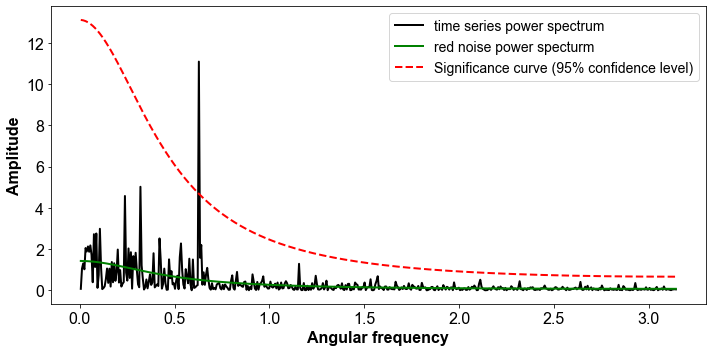

In [10]:
plt.figure(figsize=(10,5))
plt.plot(omega, scaledPower, color='k', label='time series power spectrum')
plt.plot(omega, scaledRN, color='green', label='red noise power specturm')
plt.plot(omega, sigCurve, 'r--', label='Significance curve (95% confidence level)')
plt.legend()
plt.xlabel('Angular frequency')
plt.ylabel('Amplitude');

Fig.1 Power spectrum of time series with no smoothing and tapering.

## Case b)

Lowest resolved frequency: 2$\pi$ per N. No window tapering. Smooth the spectra using a 5-point running mean. (e.g., the value of $\phi(\omega_3)$ is the average of all the values of the spectrum between $\phi(\omega_1)$ and $\phi(\omega_5)$

In [11]:
dof=2
RUNMEAN = 5
if RUNMEAN is not None:
    C2 = np.convolve(C2, np.ones((RUNMEAN,))/RUNMEAN)[(RUNMEAN-1):] #Fast way of doing a running mean.
    dof*=RUNMEAN # Applying a running mean increases the degrees of freedom for significance
                 # testing.


In [12]:
k = np.arange(1,nyquist+1) # Wavenumbers
omega = 2*np.pi*k/N # Angular frequency

rho = np.corrcoef(y_detrend[1:], y_detrend[:-1])[0,1] # Lag-1 correlation of the detrended time series.
sigma_e2 = (1-rho**2)*np.var(y_detrend)

rnPower = 4*sigma_e2**2/N/(1+rho**2-2*rho*np.cos(omega))

delta = omega[1]-omega[0]
scaledPower = C2/np.nansum(delta*C2)
scaledRN = rnPower/np.nansum(delta*rnPower)

alphaStar = 0.05
alpha = alphaStar/nyquist

sigChi2 = stats.chi2.isf(alpha,dof) # Chi-squared value for the nominal alpha value for your 95% test.

sigCurve = scaledRN / dof *sigChi2 

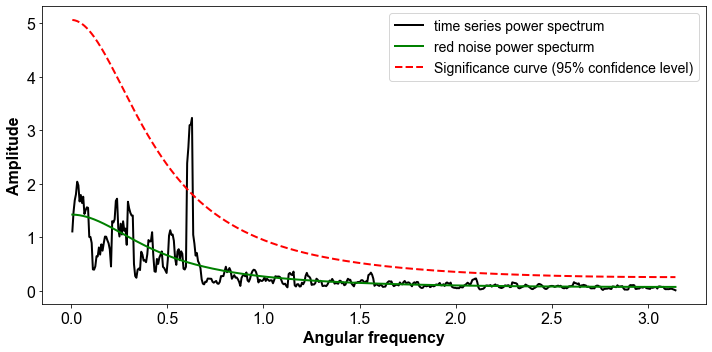

In [13]:
plt.figure(figsize=(10,5))
plt.plot(omega, scaledPower, color='k', label='time series power spectrum')
plt.plot(omega, scaledRN, color='green', label='red noise power specturm')
plt.plot(omega, sigCurve, 'r--', label='Significance curve (95% confidence level)')
plt.legend()
plt.xlabel('Angular frequency')
plt.ylabel('Amplitude');

Fig.2 Power specturm of time series with running mean (window=5).

## Case c:

Lowest resolved frequency: 2$\pi$ per N/5. Hanning window. No smoothing. Use an overlap corresponding to half the length of each subset of the data (i.e., 1:200, 101:300,...). Note that since there is an overlap between successive subsets, you will acturally be calculating spectra for 9 subsets of the data.

In [14]:
SUBSET= 5
SEGMENTS= SUBSET*2-1
num = len(y_detrend)/SUBSET #The length of the time series over which to conduct power spectrum analysis

N = int(np.floor(num/2.)*2) # Get an even number of points for the power spectrum analysis.


nyquist = int(N/2)


dt = 1. # Timestep
T = dt*N #Total time length

i = np.arange(1,N+1) #Discrete counter for the points in y.

A = np.ones((SEGMENTS, nyquist+1))*np.nan
B = np.ones((SEGMENTS, nyquist+1))*np.nan

w= signal.windows.hann(N)

rho= []
for n in range(SUBSET):
    ysub = y_detrend[n*N:(n+1)*N]
    rho.append(stats.pearsonr(ysub[1:], ysub[:-1])[0])
    ysub*= w
    
    for k in range(1, nyquist): #resolve the lowest frequency
        A[n,k] = 2./N*(ysub*np.cos(2*np.pi*k*i*dt/T)).sum()
        B[n,k] = 2./N*(ysub*np.sin(2*np.pi*k*i*dt/T)).sum()
    k= nyquist
    A[n,k] = 1/N*(ysub*np.cos(np.pi*N*i*dt/T)).sum()
    B[n,k]= 0 
    


In [15]:
start= N//2
for n in range(SUBSET, SEGMENTS):
    ysub= y_detrend[start:start+N]
    print(start,start+N)
    rho.append(stats.pearsonr(ysub[1:], ysub[:-1])[0])
    ysub*= w
    for k in range(1, nyquist): #resolve the lowest frequency
        A[n,k] = 2./N*(ysub*np.cos(2*np.pi*k*i*dt/T)).sum()
        B[n,k] = 2./N*(ysub*np.sin(2*np.pi*k*i*dt/T)).sum()
    k= nyquist
    A[n,k] = 1/N*(ysub*np.cos(np.pi*N*i*dt/T)).sum()
    B[n,k]= 0 
    start+=N

100 300
300 500
500 700
700 900


In [16]:
C2= A**2 + B**2
C2= C2[:,1:]
C2 = np.nanmean(C2, axis=0)

In [17]:
fw= 1.2
dof= np.ceil(2*SUBSET*fw)

print(dof)

12.0


In [18]:
#significance test
k = np.arange(1,nyquist+1) # Wavenumbers
omega = 2*np.pi*k/N # Angular frequency

meanrho = np.mean(rho)

sigma_e2 = (1-meanrho**2)*np.var(y_detrend)

rnPower = 4*sigma_e2**2/N/(1+meanrho**2-2*meanrho*np.cos(omega))


In [19]:
delta = omega[1]-omega[0]
scaledPower = C2/np.nansum(delta*C2)
scaledRN = rnPower/np.nansum(delta*rnPower)

alphaStar = 0.05
alpha = alphaStar/nyquist

sigChi2 = stats.chi2.isf(alpha,dof) # Chi-squared value for the nominal alpha value for your 95% test.

sigCurve = scaledRN / dof *sigChi2 

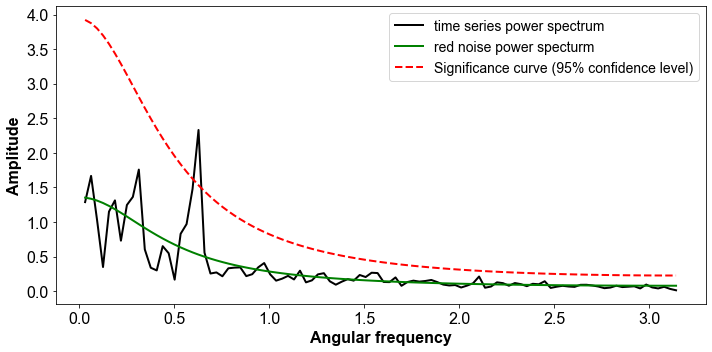

In [20]:
plt.figure(figsize=(10,5))
plt.plot(omega, scaledPower, color='k', label='time series power spectrum')
plt.plot(omega, scaledRN, color='green', label='red noise power specturm')
plt.plot(omega, sigCurve, 'r--', label='Significance curve (95% confidence level)')
plt.legend()
plt.xlabel('Angular frequency')
plt.ylabel('Amplitude');

Fig.3 Power spectrum of time series with tapering window applied.

__Summary__:

In this exercise, we practiced decomposing the time series time with respect to its frequency domain and also applied techniques (running mean, window) to increase the degree of freedom and taper. In this case, we used the experimental red noise power spectrum to test against null hypothesis (i.e., no significant difference between this time series data with red noise), and the chi-square distribution is used.

For case a, one can see the prominent oscillations and the strong amplitude in the low angular frequency (i.e., 0-0.6). The significance test (y_sig=5.0) helps to identify the signal (y=11.5) which stands out, and its frequency is at around 0.6.

For case b, because of the running mean, the amplitudes become smooth, but still the strong amplitude (y=3.2) above the signigicance level (y_sig=1.9) is promising as the first case. Because the degree of freedom increased from 2 to 10, compared to case a, the significance level becomes lower.

For case c, it chops up the whole set into 9 pieces, and the lowest resolved frequency becomes one fifth of the original and much more details are lost. Therefore, the signal is again smoothed further. But still we get the spike (y=2.4) at frequency around 0.6 above the significance level (y_sig=1.5). 

Combining them as a whole, despite different techniques conducted (i.e., running mean, window filters), we always have the dominant frequency at 0.6 for all cases, which indicate the prominent signal at that frequency. Also, most of the strong amplitudes are at low frequencies rather than high frequencies, indicating a dominant short-term periodicity. As dipicted,the significance level goes down from case a (5.0) to case b (1.9) and case c (1.5) because the degree of freedom increases fro 2 to 10 and finally to 12. Analogously, the dominant signal drops from 11.5 (case a) to 3.2 (case b) and to 2.4 (case c), owning to the details been lost through applying either running mean or tapering windows.

# Question 2

In [36]:
SPO= np.loadtxt('SPO.txt')

In [37]:
date= pd.date_range('19480101', '20151201', freq='3M')[1:]

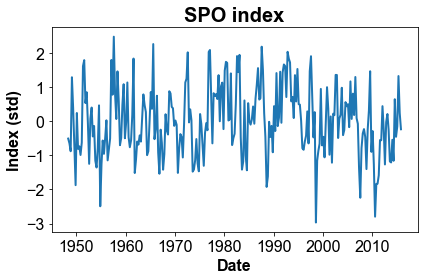

In [38]:
plt.title('SPO index', weight='bold')
plt.plot(date,SPO)
plt.ylabel('Index (std)', weight='bold')
plt.xlabel('Date', weight='bold');

Fig.4 Time series of SPO index

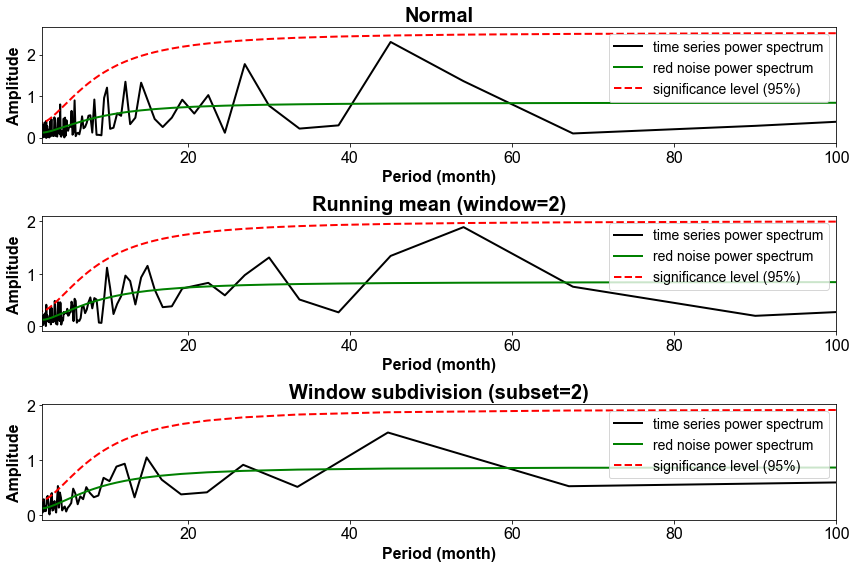

In [55]:
fig= plt.figure(figsize=(12,8))
ps = PowerSpectrum(SPO, detrend=True)
x, ps_curve, rn_curve, sig_curve= ps.normal(priori=True) #perform normal analysis with an analogy to case a
period= 2 * np.pi/x
ax= fig.add_subplot(311)
ax.plot(period, ps_curve, color='k', label='time series power spectrum')
ax.plot(period, rn_curve, color='green', label='red noise power spectrum')
ax.plot(period, sig_curve, 'r--', label='significance level (95%)');
ax.set_xlim([min(period),100])
ax.set_xlabel('Period (month)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_title('Normal', weight='bold')
ax= fig.add_subplot(312)
x, ps_curve, rn_curve, sig_curve= ps.running_mean(2,priori=True) #perform running mean smooth with an analogy to case a
period= 2 * np.pi/x
ax.plot(period, ps_curve, color='k', label='time series power spectrum')
ax.plot(period, rn_curve, color='green', label='red noise power spectrum')
ax.plot(period, sig_curve, 'r--', label='significance level (95%)');
ax.set_xlim([min(period),100])
ax.set_xlabel('Period (month)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_title('Running mean (window=2)', weight='bold')
ax= fig.add_subplot(313)
ps_window= PowerSpectrum(SPO, detrend=True, window=True, subset=2)
x, ps_curve, rn_curve, sig_curve= ps_window.window(priori=True) #perform window sub-divide analysis with an analogy to case c
period= 2 * np.pi/x
ax.plot(period, ps_curve, color='k', label='time series power spectrum')
ax.plot(period, rn_curve, color='green', label='red noise power spectrum')
ax.plot(period, sig_curve, 'r--', label='significance level (95%)');
ax.set_xlim([min(period),100])
ax.set_xlabel('Period (month)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_title('Window subdivision (subset=2)', weight='bold');


Fig.5 The power spectrum of time series by three approaches (from top to down): (a) normal without processing; (b) running mean (window=2); (c) tapering (subset=2).

__Summary__:

Three approaches applied similar to the previous problem, and one common prominent peak at around 3 month period is retained which exceed the 95% significance level. Also we can still see some interannual scale peaks that are slightly less than significance level.

Therefore, This SPO index has significant seasonal cycle, which corroborates with the finding from the original paper "SPO variability spans a wide range of time scales (intraseasonal, interannual, and even decadal) with seasonal variability maximized during austral winter."

# Question 3

In [25]:
x = np.loadtxt('HW#5TimeSeries2.txt')
y = np.loadtxt('HW#5TimeSeries3.txt')

In [26]:
SUBDIVIDE = 10 # Chop up the time series into X pieces.
SEGMENTS = 10 # Since we won't be using windows, we don't need overlapping segments.

num = y.size/SUBDIVIDE # The length of the time series over which to conduct power spectrum analysis
N = int(np.floor(num/2.)*2) # Get an even number of points for the power spectrum analysis.

nyquist = int(N/2)

dt = 1. # Timestep is 1 month.
T = dt*N 

i = np.arange(1,N+1) # Discrete counter for the points in y.

Ax = np.ones((nyquist+1,SEGMENTS))*np.nan 
Bx = np.ones((nyquist+1,SEGMENTS))*np.nan 

Ay = np.ones((nyquist+1,SEGMENTS))*np.nan 
By = np.ones((nyquist+1,SEGMENTS))*np.nan 

#-------------------------------------------------------------------------
# Calculations for time series #1 (x).
#-------------------------------------------------------------------------
start = 0
for m in range(SEGMENTS):
    xsub = x[start:start+N] # define the segment of x from start to start + N
    xsub = signal.detrend(xsub) # Detrend xsub
    xsub = (xsub - xsub.mean())/xsub.std() # Standardize xsub
    
    for k in range(1,nyquist):
        Ax[k,m] = 2./N*(xsub*np.cos(2*np.pi*k*i*dt/T)).sum()
        Bx[k,m] = 2./N*(xsub*np.sin(2*np.pi*k*i*dt/T)).sum()
    
    k = nyquist
    Ax[k,m] = 1/N*(xsub*np.cos(np.pi*N*i*dt/T)).sum()
    Bx[k,m] = 0.
    
    start+=N #Move to the next segment.
    

#-------------------------------------------------------------------------
# Calculations for time series #2 (y).
#-------------------------------------------------------------------------
start = 0
for m in range(SEGMENTS):
    ysub = y[start:start+N] # define the segment of y from start to start + N
    ysub = signal.detrend(ysub) # Detrend ysub
    ysub = (ysub - ysub.mean())/ysub.std() # Standardize ysub
    
    for k in range(1,nyquist):
        Ay[k,m] = 2./N*(ysub*np.cos(2*np.pi*k*i*dt/T)).sum()
        By[k,m] = 2./N*(ysub*np.sin(2*np.pi*k*i*dt/T)).sum()
    
    k = nyquist
    Ay[k,m] = 1/N*(ysub*np.cos(np.pi*N*i*dt/T)).sum()
    By[k,m] = 0.
    
    start+=N #Move to the next segment.


In [27]:
Fxx = np.nanmean(Ax**2, axis=1) + np.nanmean(Bx**2, axis=1)
Fyy = np.nanmean(Ay**2, axis=1) + np.nanmean(By**2, axis=1)

Fxx = Fxx[1:]
Fyy = Fyy[1:]

Fxy = np.real(Ax*Ay + Bx*By) + np.imag(Ax*By+Bx*Ay)
Fxy = Fxy[1:]

meanCo = np.nanmean(Ax*Ay + Bx*By, axis=1)[1:]
meanQ = np.nanmean(Ax*By+Bx*Ay, axis=1)[1:]

coh2 = (meanCo**2+meanQ**2)/(Fxx*Fyy)

sigCoh2 = .146 # 95% level from Hartmann's notes 
               # for 20 degrees of freedom (10 subdivisions x 2 d.o.f each)
    
k = np.arange(1,nyquist+1) # Wavenumbers
omega = 2*np.pi*k/float(T) # Angular frequency

delta = omega[1]-omega[0]
scaledPowerX = Fxx/np.nansum(delta*Fxx)
scaledPowerY = Fyy/np.nansum(delta*Fyy)



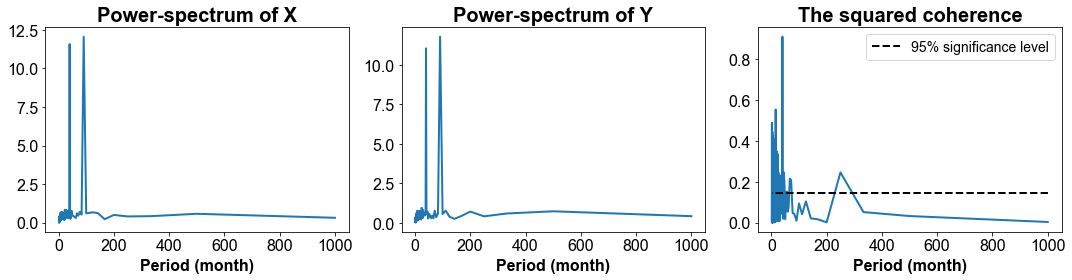

In [28]:
period = 2*np.pi/omega # In months - use for your x-axis in your plot.

fig= plt.figure(figsize=(15,4))
ax= fig.add_subplot(131)
ax.plot(period, scaledPowerX)
ax.set_title('Power-spectrum of X', weight='bold')
ax.set_xlabel('Period (month)')
ax= fig.add_subplot(132)
ax.plot(period, scaledPowerY)
ax.set_title('Power-spectrum of Y', weight='bold')
ax.set_xlabel('Period (month)')
ax= fig.add_subplot(133)
ax.set_title('The squared coherence', weight='bold')
ax.plot(period, coh2)
ax.set_xlabel('Period (month)')
ax.plot(period, [0.146]*len(omega), 'k--', label='95% significance level')
ax.legend();

Fig.6 Cross-power spectrum of time series 1 (leftmost) and 2 (middle) with respect to period. The rightmost is the sqared coherence with period.

In [29]:
maxCohIndex = np.argsort(coh2)[::-1]
maxPeriod = period[maxCohIndex][:2]

print(maxPeriod)

phaseAngle = np.arctan2(meanQ[maxCohIndex][0], meanCo[maxCohIndex][0]) *180 / np.pi

print('Phase angle for the first dominant peak:', phaseAngle.round(1), 'degrees')

phaseAngle = np.arctan2(meanQ[maxCohIndex][1], meanCo[maxCohIndex][1]) *180 / np.pi

print('Phase angle for the second dominant peak:', phaseAngle.round(1), 'degrees')

[40.    15.625]
Phase angle for the first dominant peak: 46.7 degrees
Phase angle for the second dominant peak: -37.2 degrees


In [30]:
N = 7 # Filter order
Wn = 2./maxPeriod[0] #Threshold frequency (in Nyquist units of 1/(2*dt)) For example, for a 12-month low-pass filter, you would use
       #Wn = 2./12.

b,a = signal.butter(N, Wn)

In [31]:
xLowPass = signal.filtfilt(b,a,x)
yLowPass = signal.filtfilt(b,a,y)

lags = np.arange(-300,301) # Make a range of lags.
lagCorr = np.ones((lags.size,))*np.nan

for n,ilag in enumerate(lags):    
    if ilag<0: lagCorr[n] = stats.pearsonr(xLowPass[:ilag], yLowPass[abs(ilag):])[0]
    else: lagCorr[n] = stats.pearsonr(xLowPass[ilag:], yLowPass[:len(yLowPass)-ilag])[0]

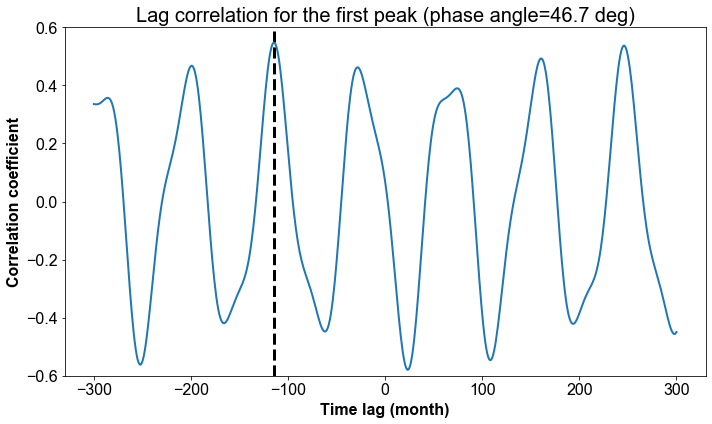

In [32]:
plt.figure(figsize=(10,6))
plt.plot(lags, lagCorr)
plt.xlabel('Time lag (month)')
plt.ylabel('Correlation coefficient')
plt.vlines(lags[np.argmax(lagCorr)], -.6, .6, linestyle='dashed', linewidth=3)
plt.ylim([-.6,.6])
plt.title('Lag correlation for the first peak (phase angle=46.7 deg)');

Fig.7 The lag correlation between low-filtered time series 1 and time series 2 at phase angle 46.7. The vertical line represents the strongest correlation.

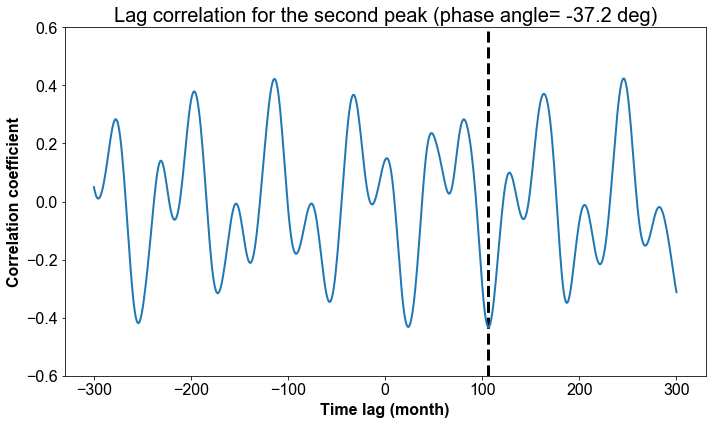

In [33]:
N = 7 # Filter order
Wn = 2./maxPeriod[1] #Threshold frequency (in Nyquist units of 1/(2*dt)) For example, for a 12-month low-pass filter, you would use
       #Wn = 2./12.

b,a = signal.butter(N, Wn)
xLowPass = signal.filtfilt(b,a,x)
yLowPass = signal.filtfilt(b,a,y)

lags = np.arange(-300,301) # Make a range of lags.
lagCorr = np.ones((lags.size,))*np.nan

for n,ilag in enumerate(lags):    
    if ilag<0: lagCorr[n] = stats.pearsonr(xLowPass[:len(yLowPass)-abs(ilag)], yLowPass[abs(ilag):])[0]
    else: lagCorr[n] = stats.pearsonr(xLowPass[ilag:], yLowPass[:len(yLowPass)-ilag])[0]
        
plt.figure(figsize=(10,6))
plt.plot(lags, lagCorr)
plt.vlines(lags[np.argmax(abs(lagCorr))], -.6, .6, linestyle='dashed', linewidth=3)
plt.ylim([-.6,.6])
plt.xlabel('Time lag (month)')
plt.ylabel('Correlation coefficient')
plt.title('Lag correlation for the second peak (phase angle= -37.2 deg)');

Fig.8 The lag correlation between low-filtered time series 1 and time series 2 at phase angle -37.2. The vertical line represents the strongest correlation.

__Summary__:

In the first peak at which the phase angle is at 46.7 degrees, the maximum correlation occurs when time series 1 (x) leads time series 2 (y) 115 months ahead. This is explainable because the cross-spectrum is in the first quadrant in the phase diagram, which indicate that x leads y.

For the second peak (phase angle=-37.2), the maximum correlation occurs when time series 1 (x) lags time series 2 (y) by 106 months because the cross-spectrum is in the fourth quadrant, and x lags y. 